In [80]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

import hashlib
from operator import itemgetter

import decoder as decoder
import os

from cfg import *


In [81]:
#Get current working directory
cwd = os.getcwd() + "\\Recordings Google Translate"
print(cwd)
#filenames = ["\\one.wav","\\two.wav","\\three.wav","\\four.wav","\\five.wav","\\Full Sound.wav"]
filenames = ["\\1.wav","\\2.wav","\\3.wav","\\4.wav","\\5.wav","\\Full Training Set.wav"]

D:\Work\School\Year 2\RMRC\RMRC-Vision-Code\RMRC-vision\Audio\Recordings Google Translate


Fingerprinting channel 1/2 for \1.wav
Finished channel 1/2 for \1.wav


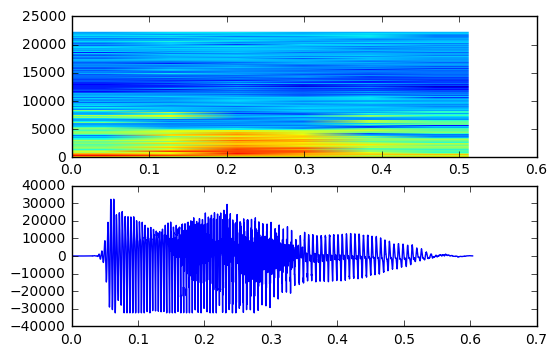

Fingerprinting channel 1/2 for \2.wav
Finished channel 1/2 for \2.wav


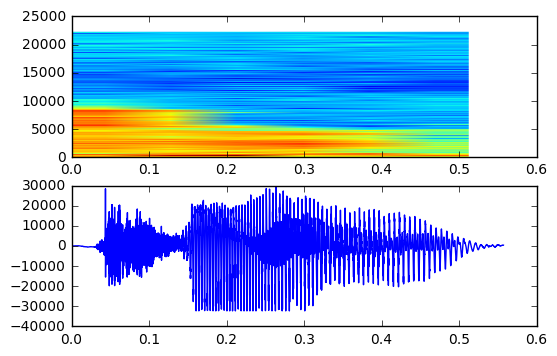

Fingerprinting channel 1/2 for \3.wav
Finished channel 1/2 for \3.wav


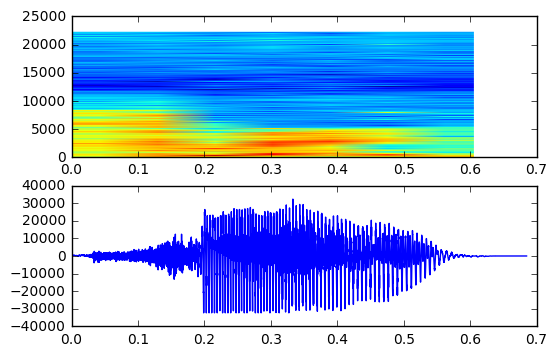

Fingerprinting channel 1/2 for \4.wav
Finished channel 1/2 for \4.wav


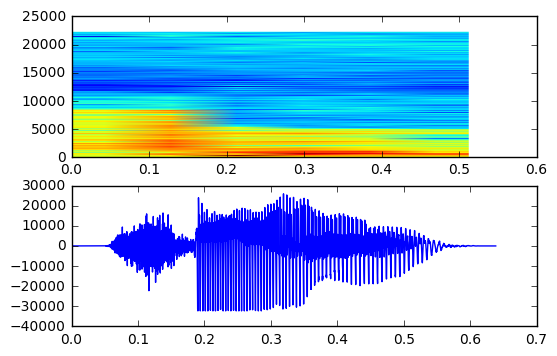

Fingerprinting channel 1/2 for \5.wav
Finished channel 1/2 for \5.wav


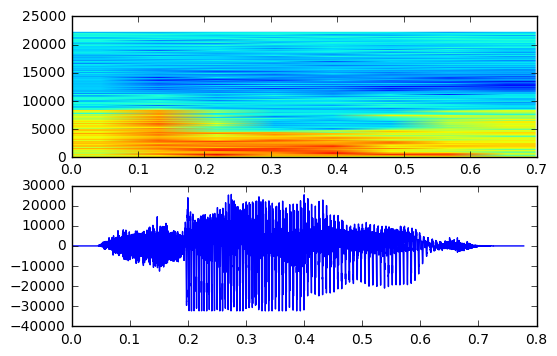

Fingerprinting channel 1/1 for \Full Training Set.wav
Finished channel 1/1 for \Full Training Set.wav


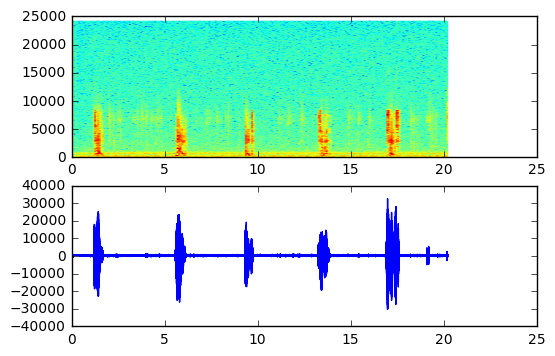

In [95]:
#Fs=DEFAULT_FS,
wsize=DEFAULT_WINDOW_SIZE
wratio=DEFAULT_OVERLAP_RATIO
fan_value=DEFAULT_FAN_VALUE
mp_min=DEFAULT_AMP_MIN

training_channels = []
test_channels = []

for counter, filename in enumerate(filenames):


    channels, Fs, file_hash = decoder.read(cwd+filename, 0)
    channel_amount = len(channels)

    print("Fingerprinting channel %d/%d for %s" % (1,
                                                       channel_amount,
                                                       filename))
    
    
    plt.subplot(211)
    
    powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(
        channels[0],
        NFFT=wsize,
        Fs=Fs,
        window=mlab.window_hanning,
        noverlap = int(int(wsize) * int(wratio)))

    print("Finished channel %d/%d for %s" % (1, channel_amount,
                                             filename))
    
    if filename != "\\Full Training Set.wav":
        training_channels.append(channels[0])
    else:
        test_channels.append(channels[0])    
    
    times = np.arange(0,len(channels[0])/Fs,1/Fs)
    plt.subplot(212)
    plt.plot(times,channels[0])
    
    plt.show()    



In [96]:
# test code which didnt work

'''
for i in range(0,1):
    cross_cor = np.correlate(test_channels[0],training_channels[i])

    plt.plot(cross_cor)
plt.show()


sig = np.repeat([0., 1., 1., 0., 1., 0., 0., 1.], 128)
sig_noise = sig + np.random.randn(len(sig))
corr = np.correlate(sig_noise, np.ones(128), mode='same') / 128

plt.subplot(311)
plt.plot(sig)
plt.subplot(312)
plt.plot(sig_noise)
plt.subplot(313)
plt.plot(corr)

'''


"\nfor i in range(0,1):\n    cross_cor = np.correlate(test_channels[0],training_channels[i])\n\n    plt.plot(cross_cor)\nplt.show()\n\n\nsig = np.repeat([0., 1., 1., 0., 1., 0., 0., 1.], 128)\nsig_noise = sig + np.random.randn(len(sig))\ncorr = np.correlate(sig_noise, np.ones(128), mode='same') / 128\n\nplt.subplot(311)\nplt.plot(sig)\nplt.subplot(312)\nplt.plot(sig_noise)\nplt.subplot(313)\nplt.plot(corr)\n\n"

In [97]:
#from fingerprint import get_2D_peaks,generate_hashes

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import (generate_binary_structure,
                                      iterate_structure, binary_erosion)

def get_2D_peaks(arr2D, plot=False, amp_min=DEFAULT_AMP_MIN):
    # http://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.morphology.iterate_structure.html#scipy.ndimage.morphology.iterate_structure
    struct = generate_binary_structure(2, 1)
    neighborhood = iterate_structure(struct, 5)

    # find local maxima using our filter shape
    local_max = maximum_filter(arr2D, footprint=neighborhood) == arr2D
    background = (arr2D == 0)
    eroded_background = binary_erosion(background, structure=neighborhood,
                                       border_value=1)
    
    

    # Boolean mask of arr2D with True at peaks
    detected_peaks = local_max - eroded_background

    # extract peaks
    amps = arr2D[detected_peaks]
    j, i = np.where(detected_peaks)

    # filter peaks
    amps = amps.flatten()
    peaks = zip(i, j, amps)
    peaks_filtered = [x for x in peaks if x[2] > amp_min]  # freq, time, amp

    # get indices for frequency and time
    frequency_idx = [x[1] for x in peaks_filtered]
    time_idx = [x[0] for x in peaks_filtered]

    if plot:
        # scatter of the peaks
        fig, ax = plt.subplots()
        ax.imshow(arr2D)
        ax.scatter(time_idx, frequency_idx)
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency')
        ax.set_title("Spectrogram")
        plt.gca().invert_yaxis()
        plt.show()

    return zip(frequency_idx, time_idx)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


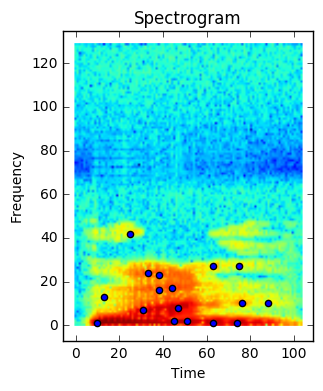

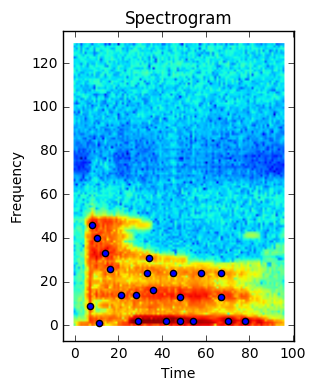

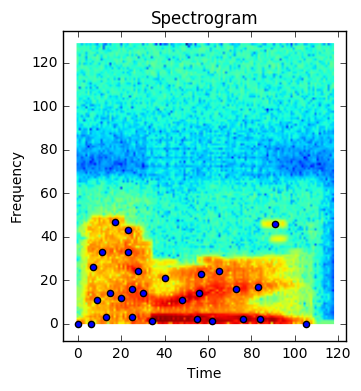

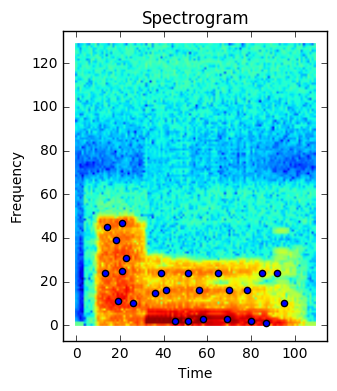

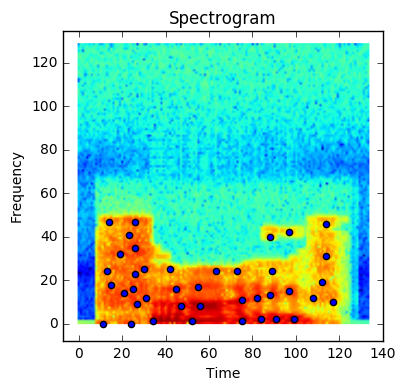

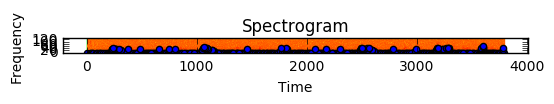

In [103]:
#Generates fingerprint for 1 audio file

def fingerprint_channel(input_audio_channel):
    arr2D = mlab.specgram(
            input_audio_channel,
            NFFT=256, #This value should be 4096 in the actual system, else there will be too many matches. 256 is used here to make the plots nicer only
            Fs=Fs,
            window=mlab.window_hanning,
            noverlap = int(int(wsize) * int(wratio)))[0]

    amp_min = DEFAULT_AMP_MIN

    # apply log transform since specgram() returns linear array
    arr2D = 10 * np.log10(arr2D)
    arr2D[arr2D == -np.inf] = 0  # replace infs with zeros

    local_maxima = get_2D_peaks(arr2D, plot=True, amp_min=DEFAULT_AMP_MIN)

for audio_channel in training_channels:
    fingerprint_channel(audio_channel)
    
for audio_channel in test_channels:
    fingerprint_channel(audio_channel)


#generate_hashes(local_maxima, fan_value=fan_value)

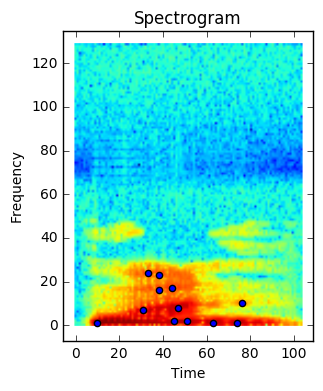

In [93]:
freq = []
time = []
for i in local_maxima:
    freq.append(i[0])
    time.append(i[1])
    
fig, ax = plt.subplots()
ax.imshow(arr2D)
ax.scatter(time, freq)

ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_title("Spectrogram")

ax.invert_yaxis()

plt.show()


### Can ignore everything below ###

In [ ]:
#Function to generate fingerprint for input audio file
def fingerprint_o(channel, Fs=DEFAULT_FS):
    
    wsize=DEFAULT_WINDOW_SIZE
    wratio=DEFAULT_OVERLAP_RATIO
    fan_value=DEFAULT_FAN_VALUE
    amp_min=DEFAULT_AMP_MIN
    
    arr2D = mlab.specgram(
        channel,
        NFFT=wsize,
        Fs=Fs,
        window=mlab.window_hanning,
        noverlap = int(int(wsize) * int(wratio)))[0]

    # apply log transform since specgram() returns linear array
    arr2D = 10 * np.log10(arr2D)
    arr2D[arr2D == -np.inf] = 0  # replace infs with zeros

    local_maxima = get_2D_peaks(arr2D, plot=False, amp_min=amp_min)

    return generate_hashes(local_maxima, fan_value=fan_value)


#Generate hashes for an audio file
def fingerprint_file(filename, limit=None, song_name=None):
    
    
    song_name, extension = os.path.splitext(os.path.basename(cwd+filename))

    channels, Fs, file_hash = decoder.read(cwd+filename, limit)
    result = set()
    channel_amount = len(channels)  

    print("Fingerprinting channel %d/%d for %s" % (1,
                                                       channel_amount,
                                                       filename))
    hashes = fingerprint_o(channels[0], Fs=Fs)
    print("Finished channel %d/%d for %s" % (11, channel_amount,
                                                 filename))
    result |= set(hashes)

    return song_name, result, file_hash


In [ ]:
song_name, result, file_hash = fingerprint_file(filenames[0])
print(song_name)
print(file_hash)
print(type(file_hash))

In [ ]:
name, res, hashes = fingerprint_file("\\Recording.wav")
song_dict={}
song_dict[name] = {
    "song_hash":hashes, "song_result":res
}


'''
sid = self.db.insert_song(song_name, file_hash)

            self.db.insert_hashes(sid, hashes)
            self.db.set_song_fingerprinted(sid)
            self.get_fingerprinted_songs()
'''

In [ ]:
print(song_dict)